In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2],
    c2 = [0.5, 2],
    w = [0.5, 1.2],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = None,
    mask = None))

see one see two 2 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 2
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 100, Accuracy: 0.9074074074074074, Loss: 0.5516112645467123
Checkpoint 200, Accuracy: 0.9074074074074074, Loss: 0.5516112645467123
Checkpoint 300, Accuracy: 0.9074074074074074, Loss: 0.5516112645467123
Checkpoint 400, Accuracy: 0.9074074074074074, Loss: 0.5516112645467123
Checkpoint 500, Accuracy: 0.9074074074074074, Loss: 0.5516112645467123


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.6653499  0.14402439 0.19062571]
[1. 0. 0.] <-> [0.69262946 0.21227129 0.09509931]
[0. 1. 0.] <-> [0.72250444 0.27353147 0.00396406]
[1. 0. 0.] <-> [0.90660506 0.06775159 0.02564334]
[1. 0. 0.] <-> [0.6537253  0.30020759 0.04606705]
[0. 1. 0.] <-> [0.4282496  0.5674811  0.00426931]
[1. 0. 0.] <-> [0.7756454  0.15896256 0.06539206]
[1. 0. 0.] <-> [0.5522396  0.4427548  0.00500561]
[1. 0. 0.] <-> [0.90557826 0.05242715 0.04199463]
[1. 0. 0.] <-> [0.83279276 0.13116965 0.03603759]
[0. 1. 0.] <-> [0.25861576 0.7393627  0.00202158]
[0. 0. 1.] <-> [0.7742289  0.03170682 0.19406426]
[0. 1. 0.] <-> [0.28387818 0.71517944 0.00094236]
[1. 0. 0.] <-> [0.8375496  0.10921625 0.05323415]
[0. 1. 0.] <-> [0.36670363 0.63069725 0.00259918]
[1. 0. 0.] <-> [0.7699565  0.06539745 0.16464601]
[1. 0. 0.] <-> [0.73112136 0.11824238 0.15063623]
[1. 0. 0.] <-> [0.83432513 0.10945942 0.0562154 ]
[1. 0. 0.] <-> [0.7212919  0.2511012  0.02760695]
[1. 0. 0.] <-> [0.89193636 0.0599664  0.04809729]


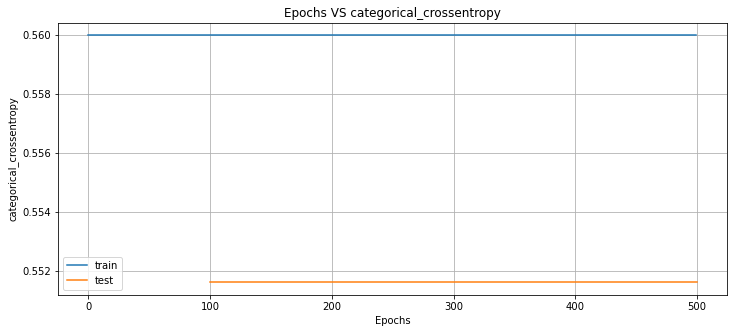

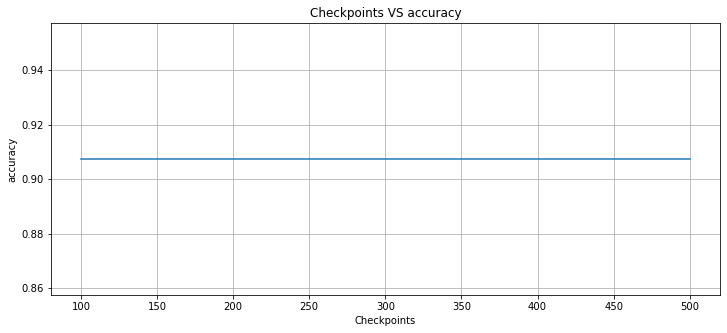

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9074074074074074, 'mean_square_error': 0.2818222660943232, 'categorical_crossentropy': 0.5516112645467123, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 13, 'tn_hit': 15, 'fn_hit': 2}, 1: {'tp_hit': 14, 'fp_hit': 2, 'tn_hit': 91, 'fn_hit': 1}, 2: {'tp_hit': 1, 'fp_hit': 0, 'tn_hit': 95, 'fn_hit': 12}}, 'checkpoint': 100} 


{'accuracy': 0.9074074074074074, 'mean_square_error': 0.2818222660943232, 'categorical_crossentropy': 0.5516112645467123, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 13, 'tn_hit': 15, 'fn_hit': 2}, 1: {'tp_hit': 14, 'fp_hit': 2, 'tn_hit': 91, 'fn_hit': 1}, 2: {'tp_hit': 1, 'fp_hit': 0, 'tn_hit': 95, 'fn_hit': 12}}, 'checkpoint': 200} 


{'accuracy': 0.9074074074074074, 'mean_square_error': 0.2818222660943232, 'categorical_crossentropy': 0.5516112645467123, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 13, 'tn_hit': 15, 'fn_hit': 2}, 1: {'tp_hit': 14, 'fp_hit': 2, 'tn_hit': 91, 'fn_hit': 1}, 2: {'tp_hit': 1, 'fp_hit': 0, 'tn_hit': 95, 'fn

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[-2.4600147  -1.7135182  -0.49498128 -1.5904936   2.88198   ]
 bias: 2.860857475756637

Neuron 1: weights:
[-2.16043119  1.80355861  0.22130416  0.08007061  0.85822933]
 bias: 0.36815650176953785

Neuron 2: weights:
[ 0.27516644  2.42762102 -1.91999528 -2.26632424 -1.1805504 ]
 bias: -1.5397553823788752

Neuron 3: weights:
[-0.06645088 -1.79641663 -2.55249283  1.62823683 -0.44814432]
 bias: 0.37191152828635143

$
Layer 2
Neuron 0: weights:
[0.22701276 1.80029261 0.59707445 1.28694972]
 bias: 2.718584248501587

Neuron 1: weights:
[ 0.82422311  1.43083406  1.95891705 -2.77565045]
 bias: 2.8048083838422837

Neuron 2: weights:
[-1.08249701 -1.96731841 -0.55486161  1.7043579 ]
 bias: 2.7089262566528394

$

